In [10]:
import pickle
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.signal import decimate,butter, lfilter, filtfilt


In [3]:
# This script reads the pickle files and stores them in a list of lists.

base_dir = '/Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1'
subjects = np.zeros(26) # contains the number of pickle files and size of each pickle for each subject
all_subjects_data = [[] for _ in range(26)]

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    num_trainig = 0

    # enter the subject directory and process the files
    if os.path.isdir(subdir_path) and subdir.startswith('S'):
        print(f"Processing files in subject: {subdir_path}")
        pattern = r'^S(\d+)$'
        if re.match(pattern, subdir):
            subject_index = int(re.match(pattern, subdir).group(1))
            #subjects.append(subject_index)

        # enter one more folder down
        for subdir_dummy in os.listdir(subdir_path):
            if not subdir_dummy.endswith('.DS_Store'):
                subjects[subject_index-1] += 1
                subdir_path_dummy = os.path.join(subdir_path, subdir_dummy)
                pattern = r'^.{8}(\d+).*$'
                if re.match(pattern, subdir_dummy):
                    training_index = int(re.match(pattern, subdir_dummy).group(1))

                # find pickles
                for filename in os.listdir(subdir_path_dummy) :
                    file_path = os.path.join(subdir_path_dummy, filename)
                
                    if filename.endswith('.pkl') and not filename.endswith('.DS_Store'):
                        print(f"Opening pickle file: {file_path}")
                        data = pd.read_pickle(file_path)
                        all_subjects_data[subject_index-1].insert(training_index-1, data)
                        #all_subjects_data.append((subject_index, training_index, data))
                    


Processing files in subject: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S5
Opening pickle file: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S5/training1__2023-07-06/labeled.pkl
Processing files in subject: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S2
Opening pickle file: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S2/training1__2023-07-15/labeled.pkl
Processing files in subject: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S3
Opening pickle file: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S3/training1__2023-07-06/labeled.pkl
Processing files in subject: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S4
Opening pickle file: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S4/training1__2023-07-06/labeled.pkl
Processing files in subject: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S26
Opening pickle file: /Users/ceren/Desktop/NEUROCESS/ERKAN_DATASET/PRESEASON_1/S26/training1__2

254028
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.  1.
  1.  1. 11.  1.  2.  1.  1.  1.]


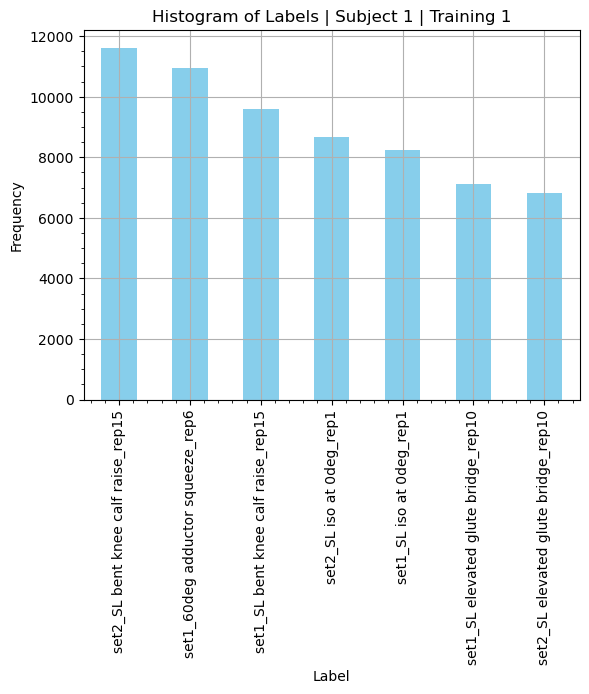

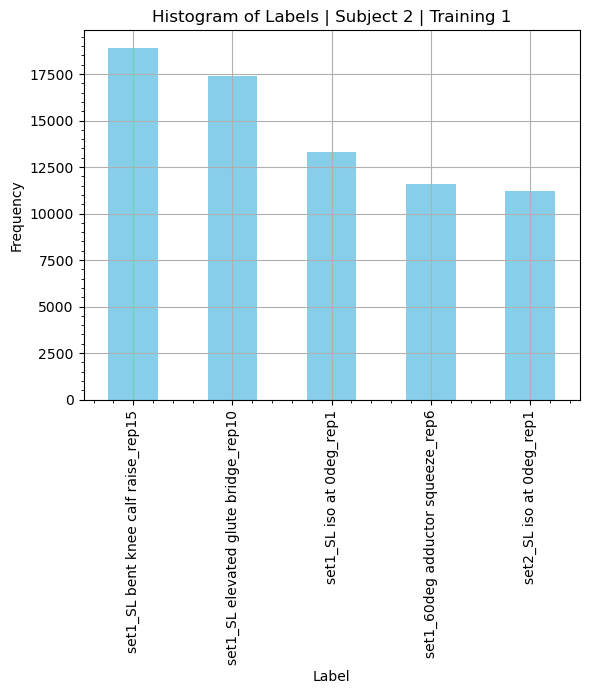

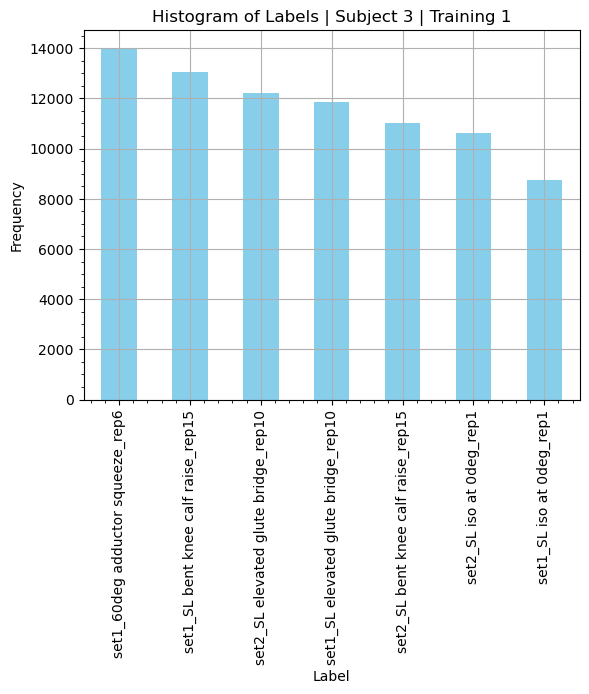

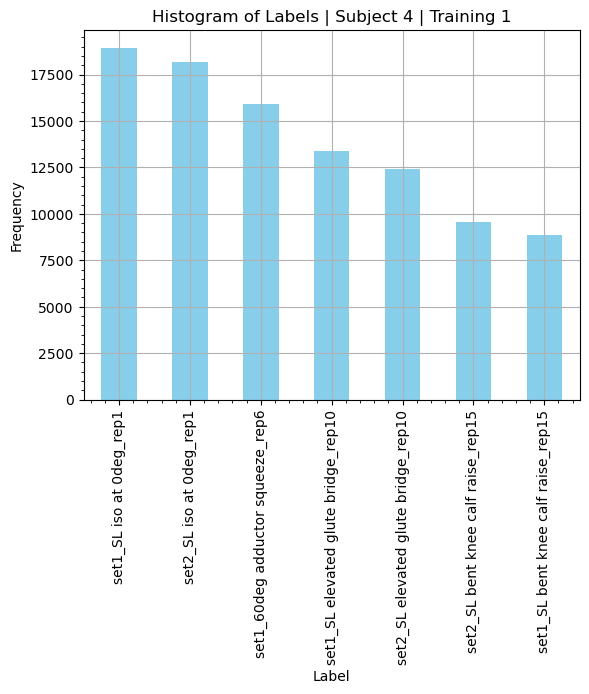

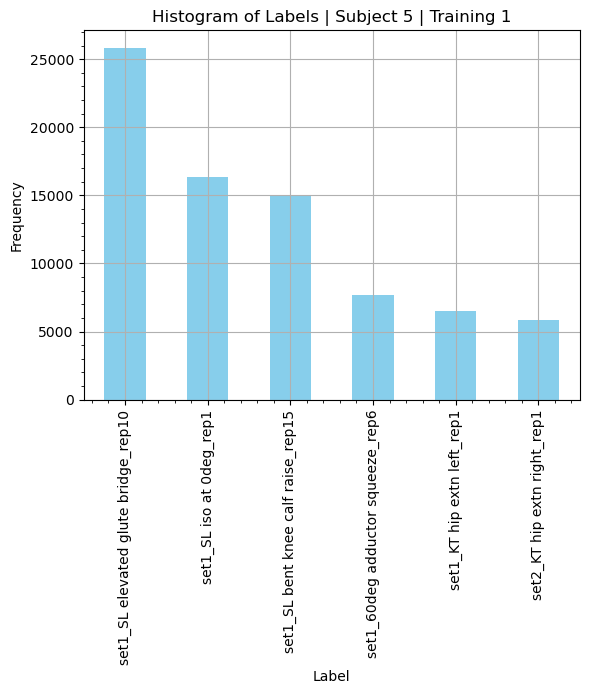

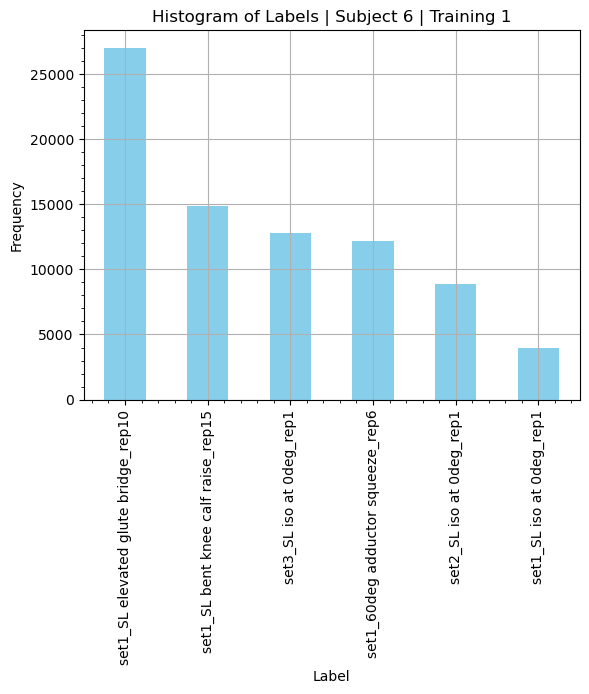

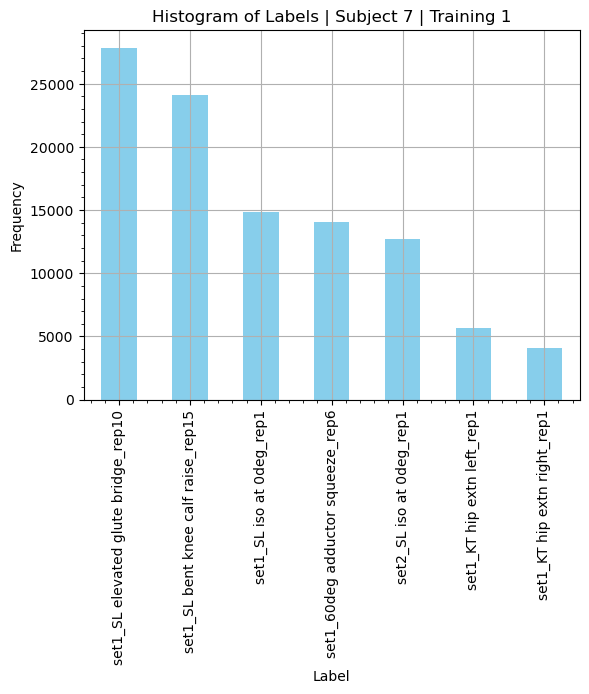

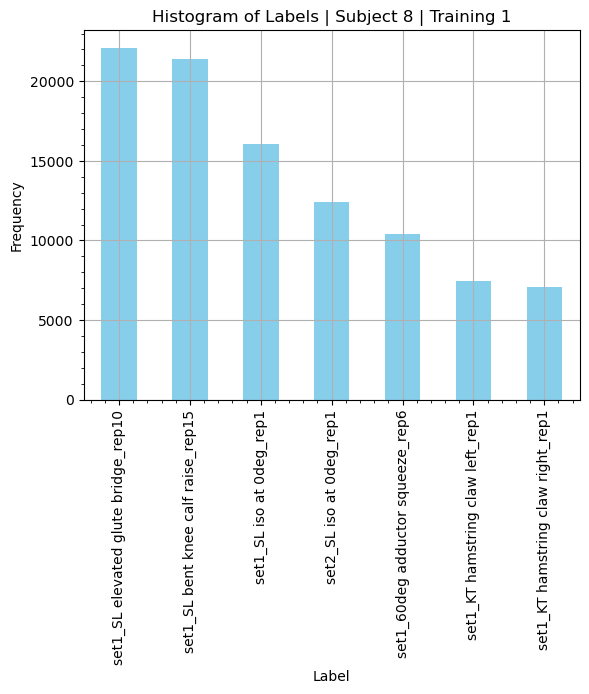

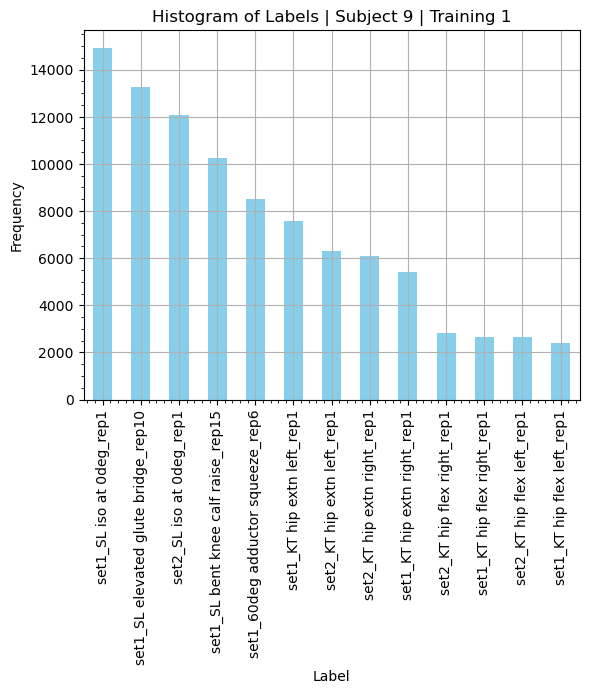

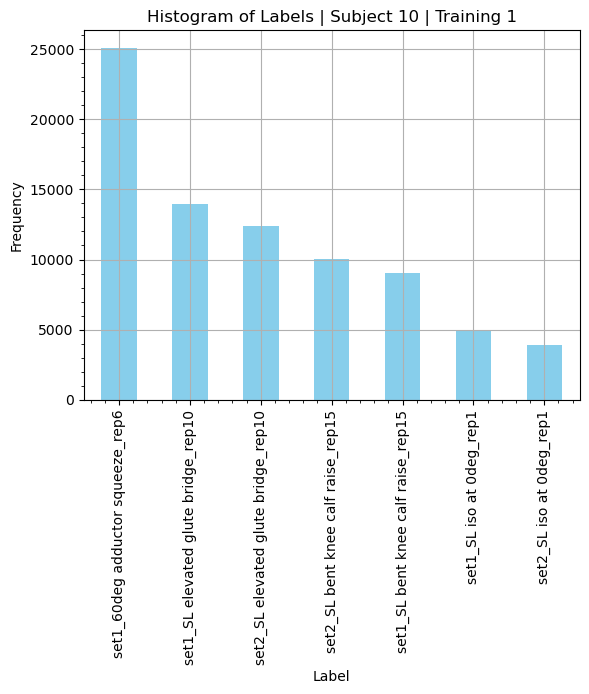

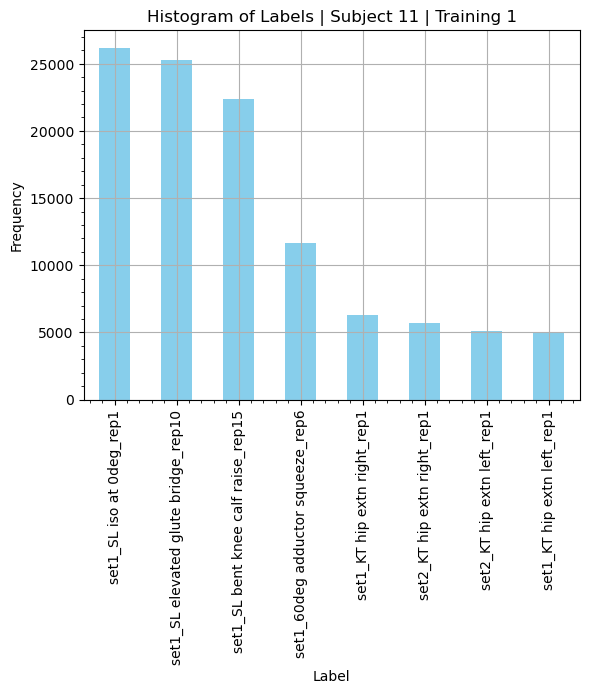

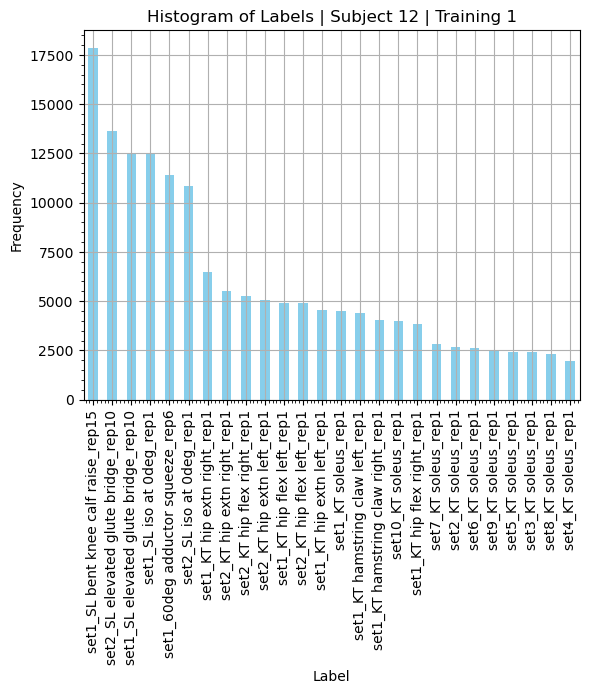

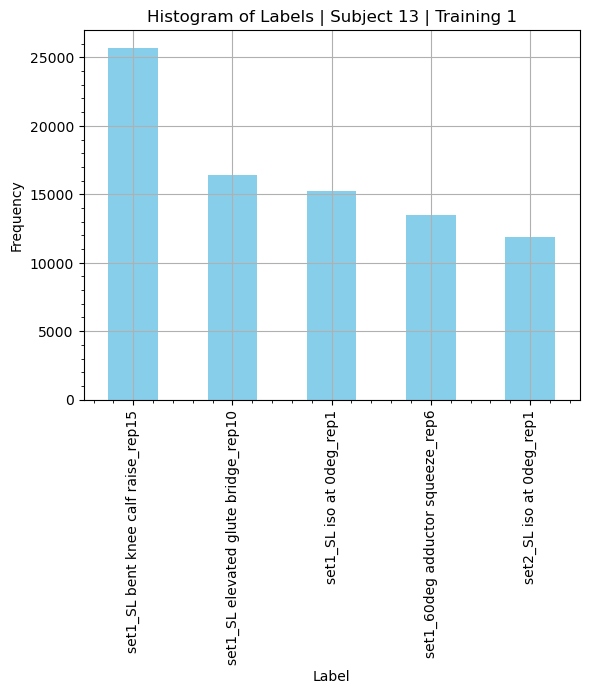

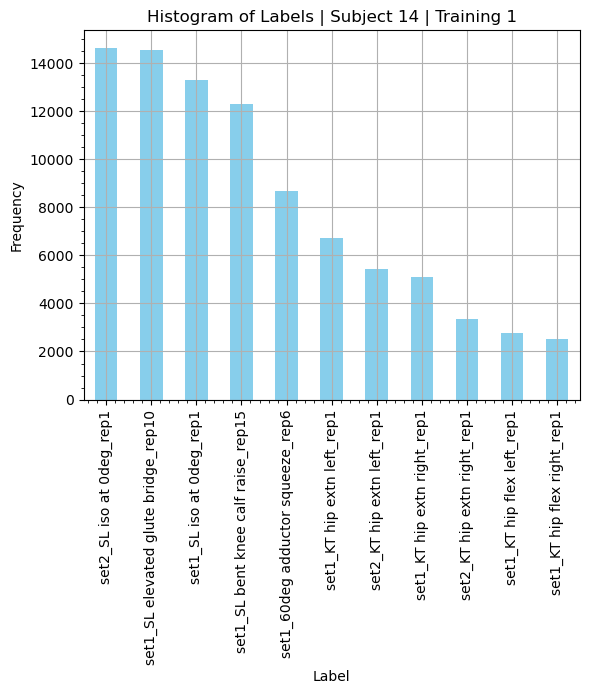

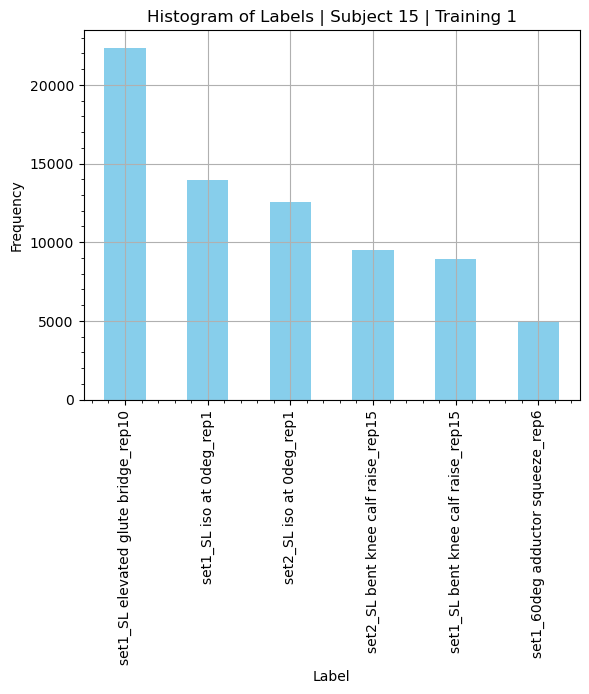

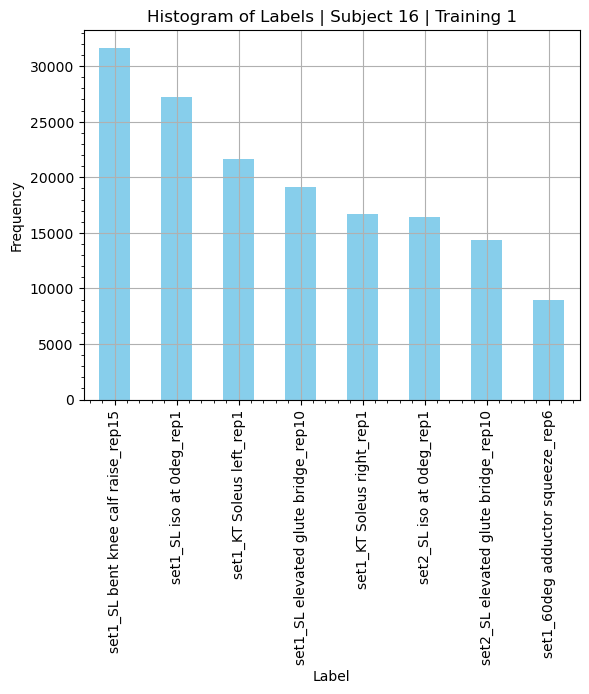

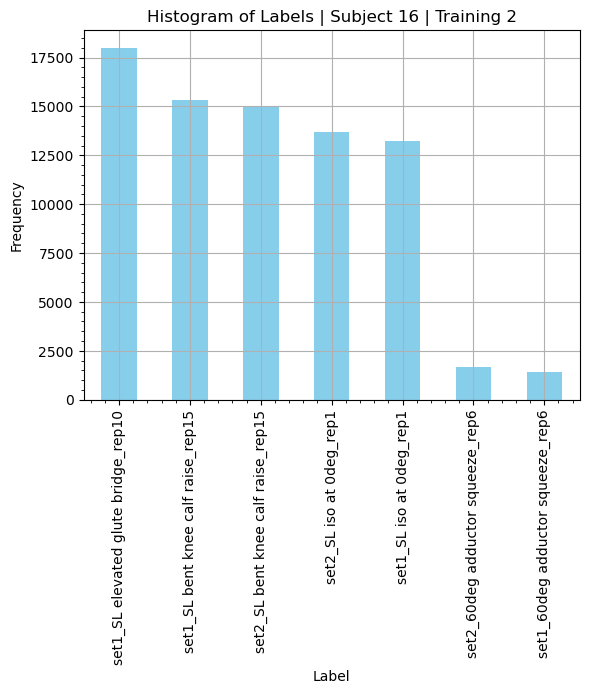

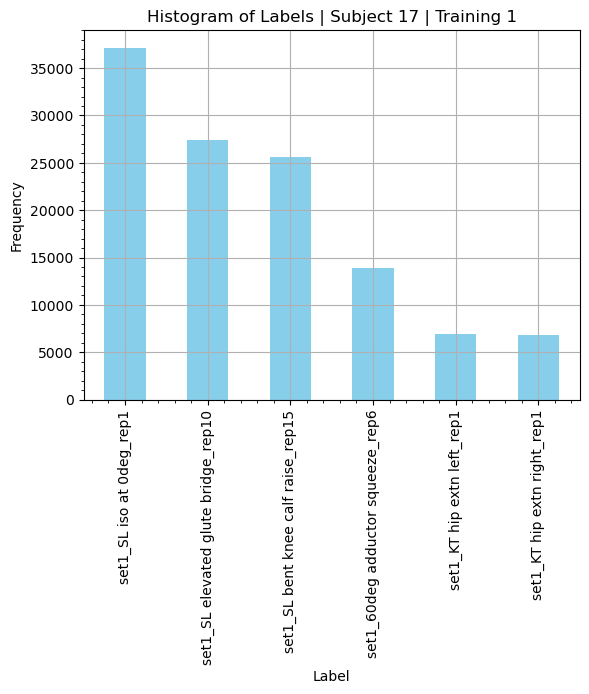

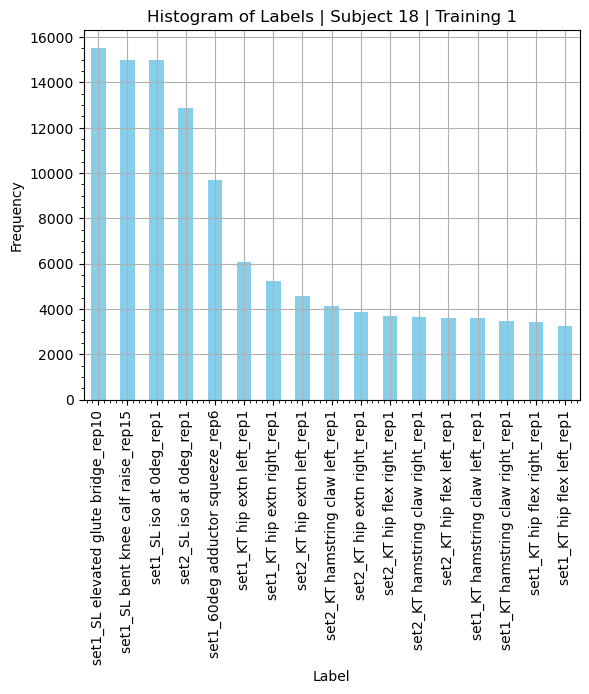

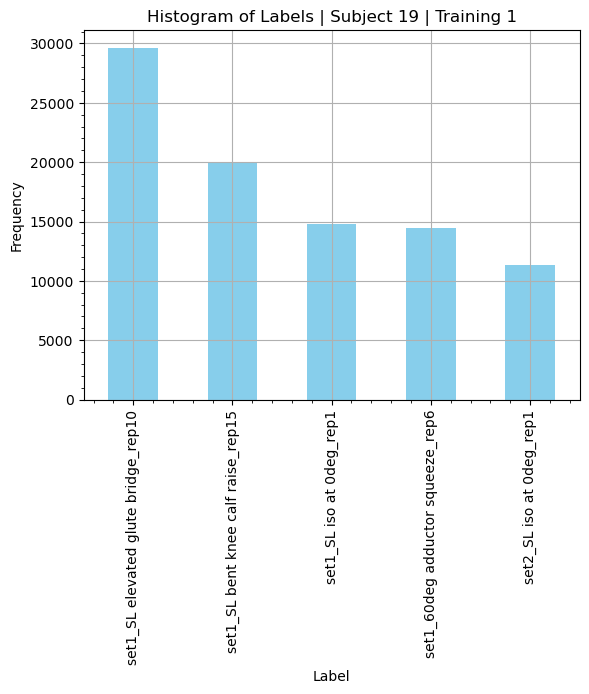

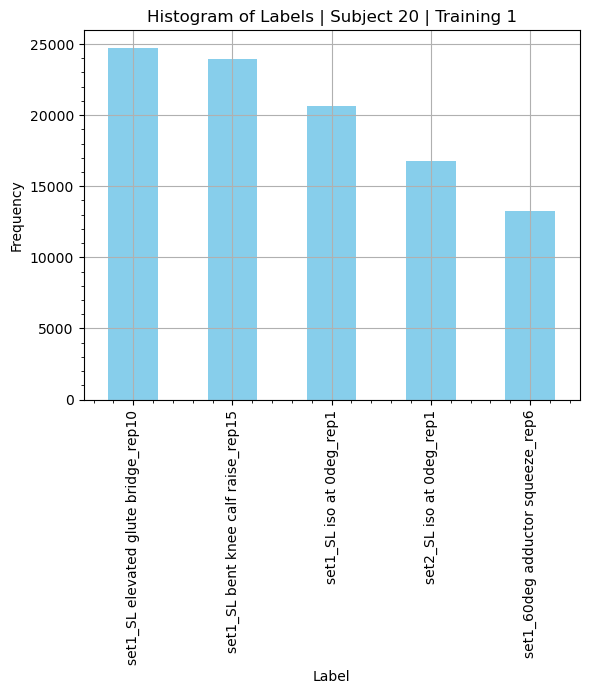

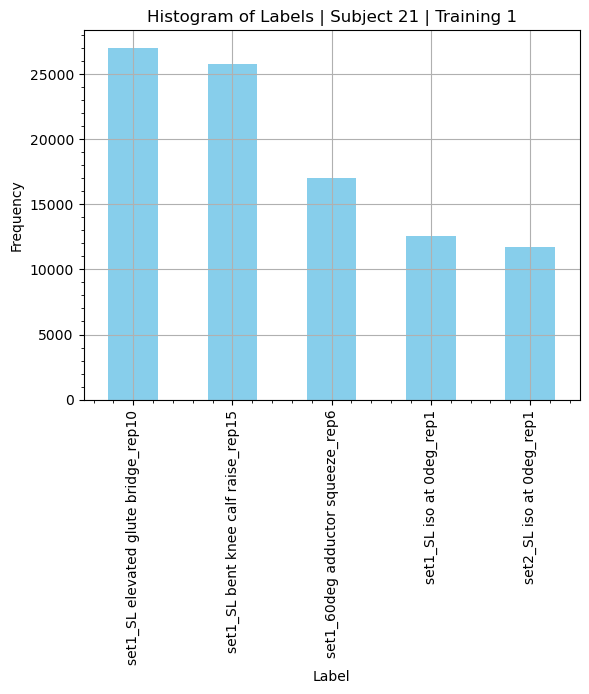

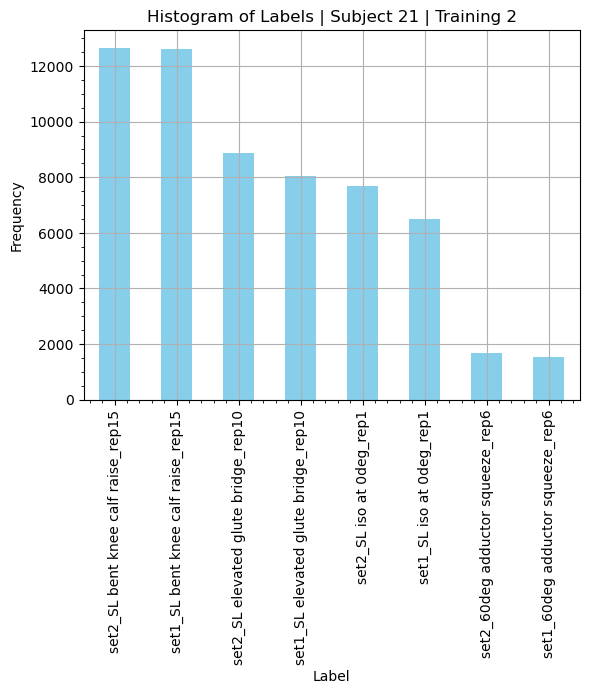

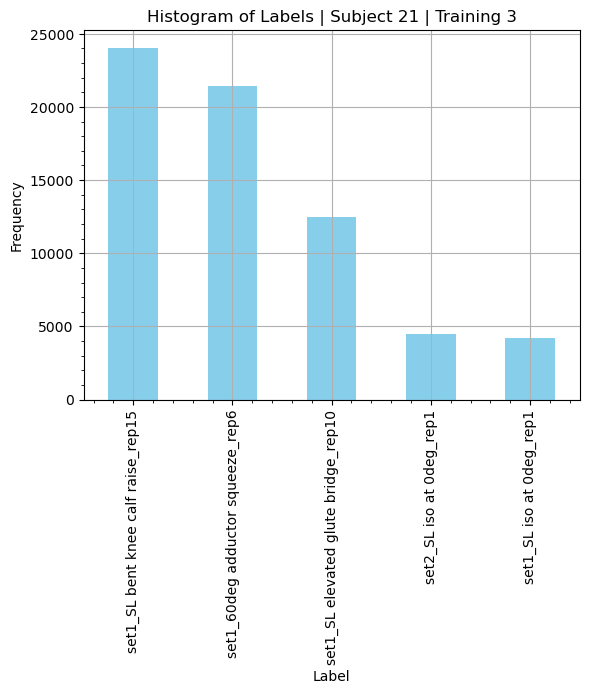

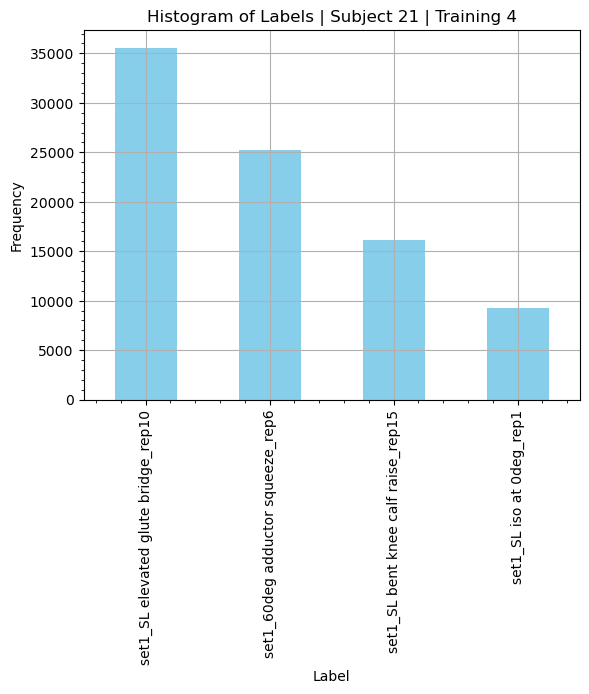

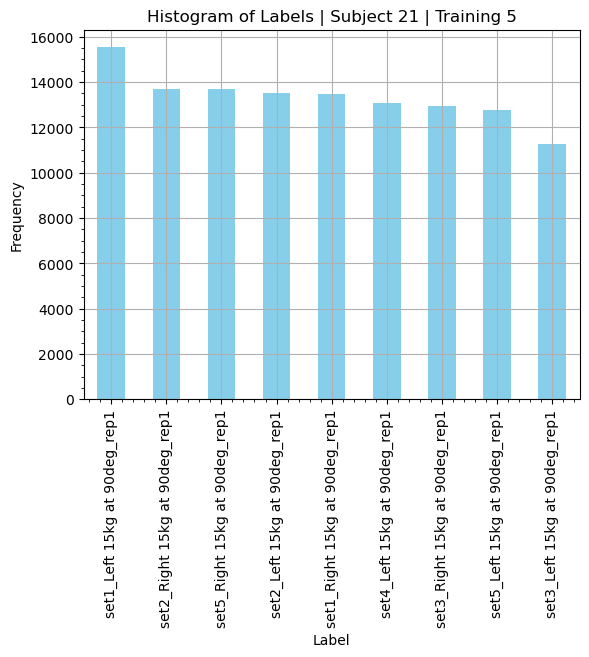

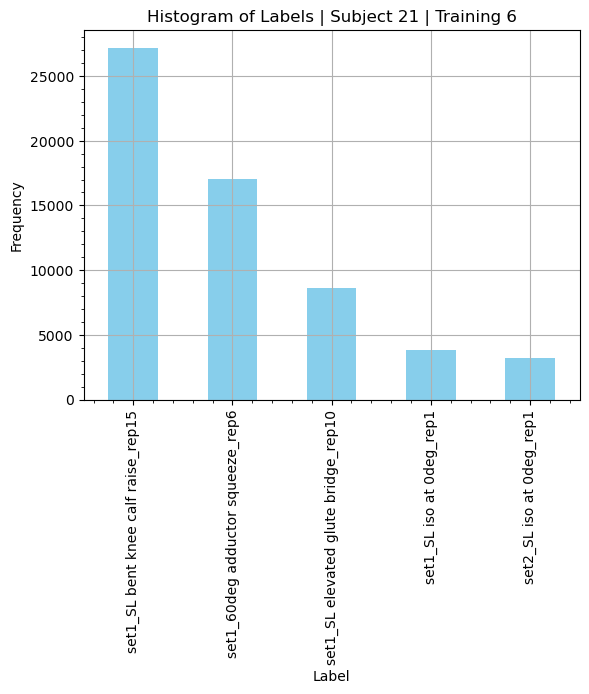

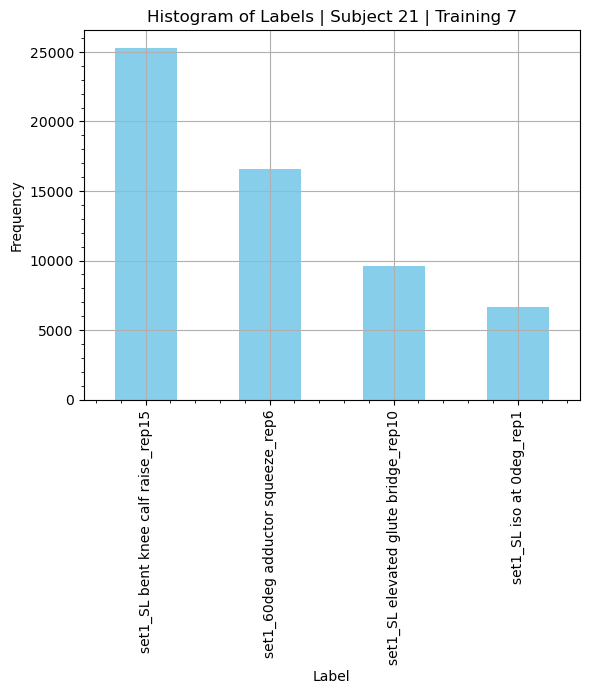

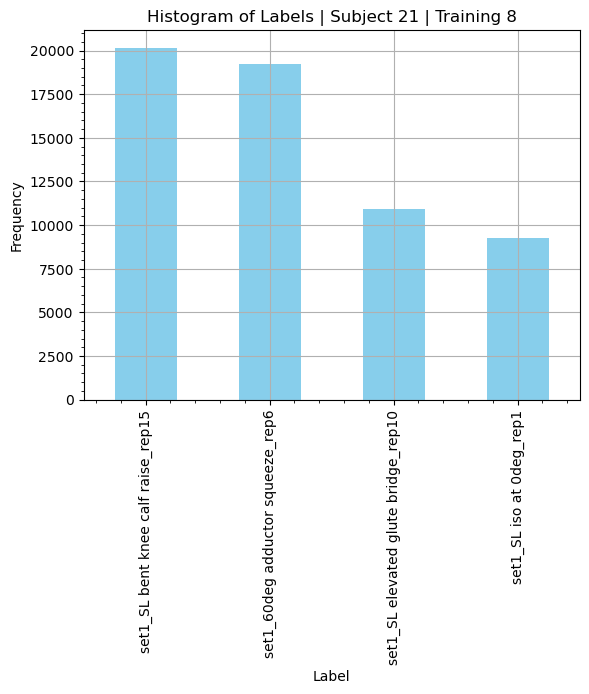

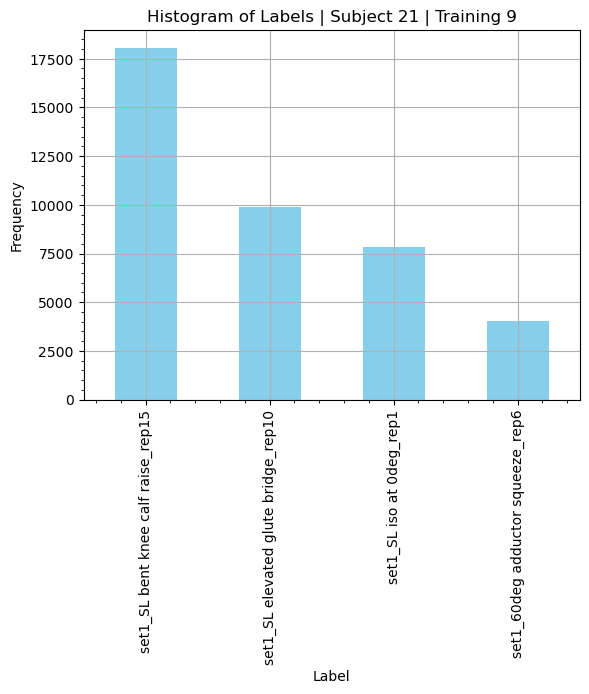

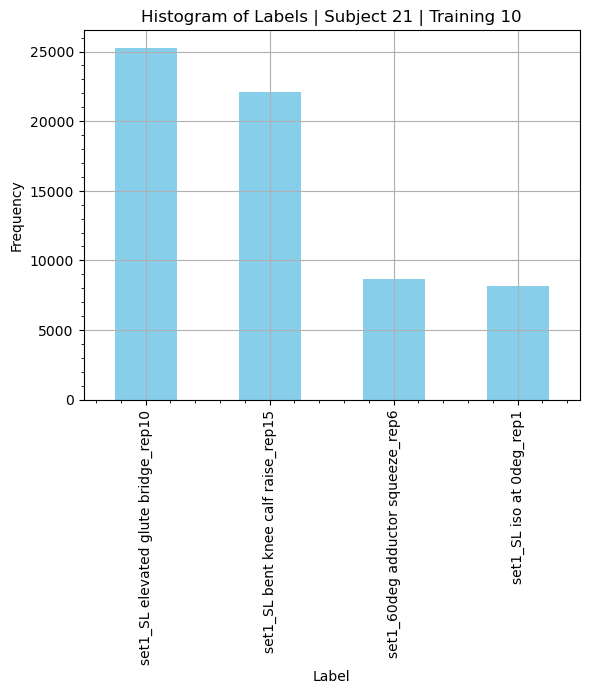

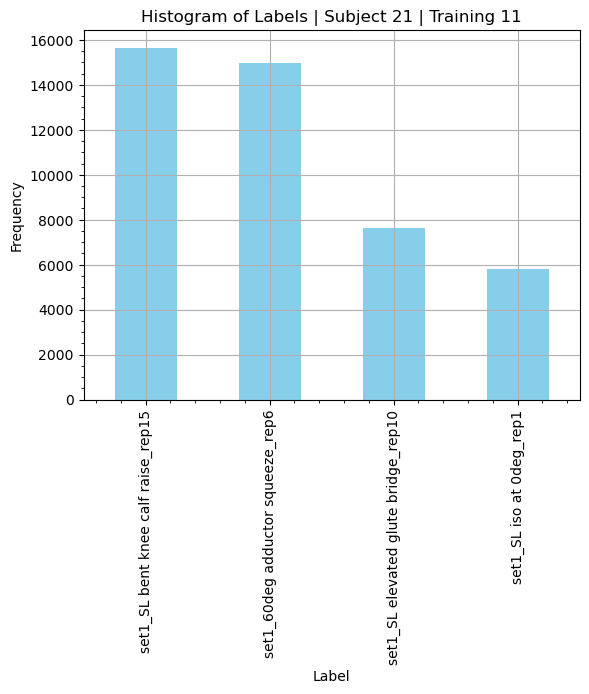

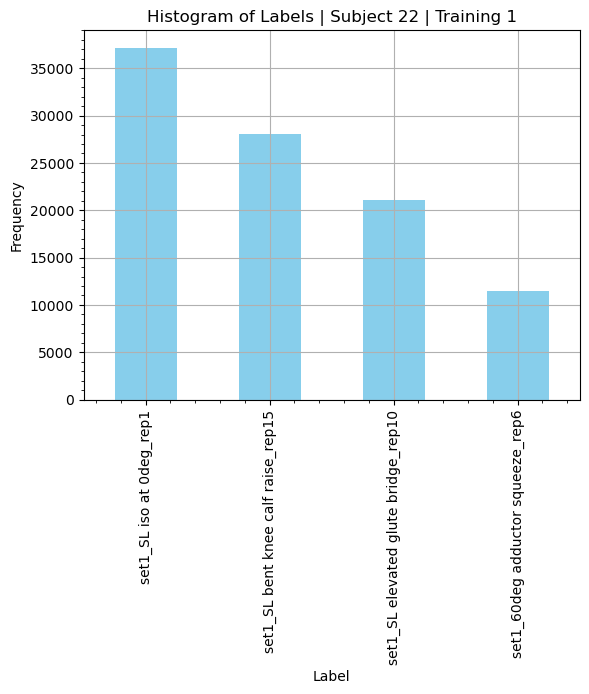

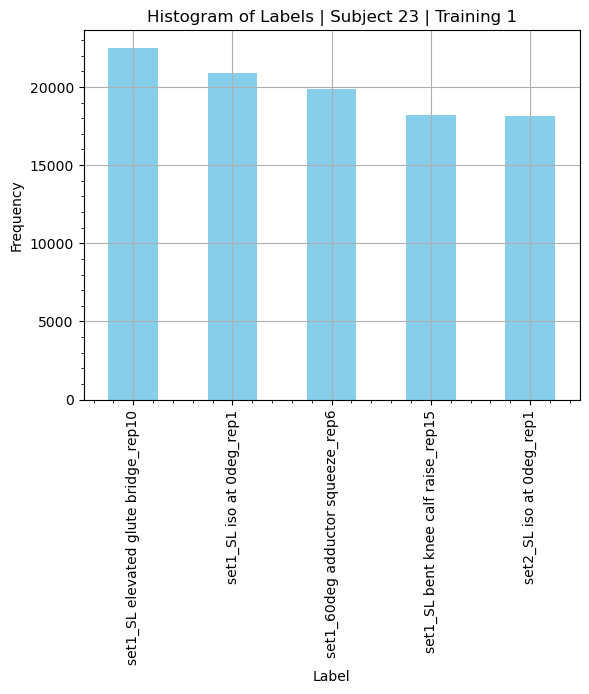

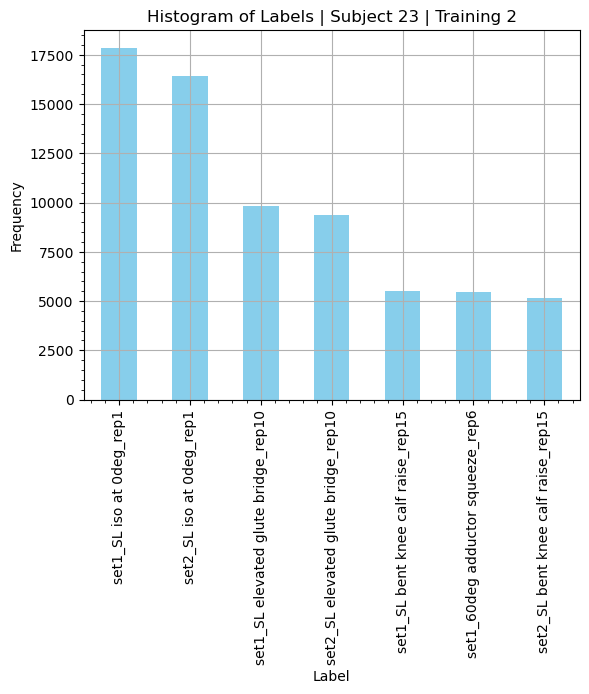

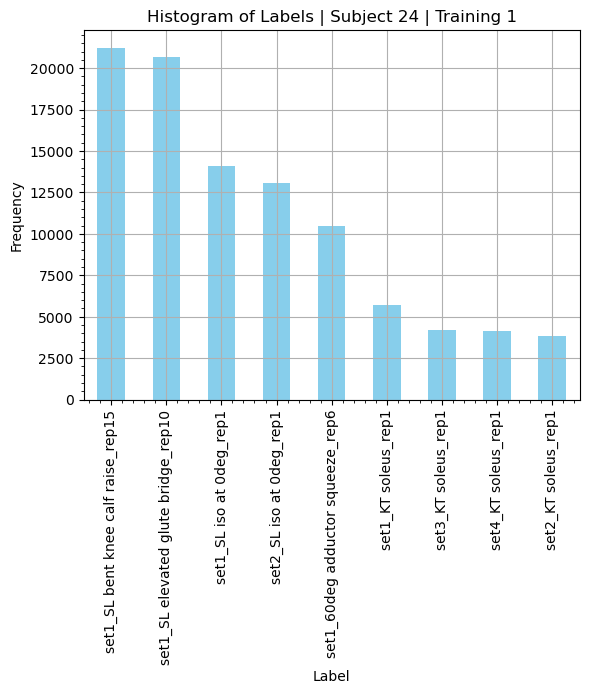

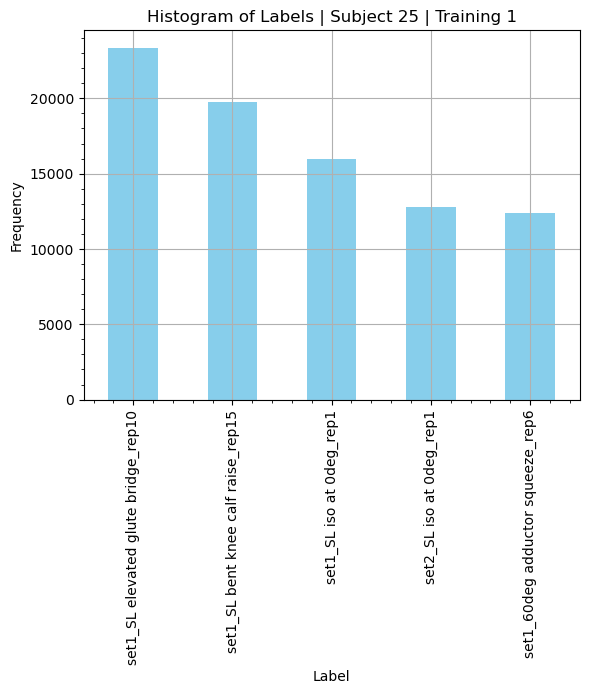

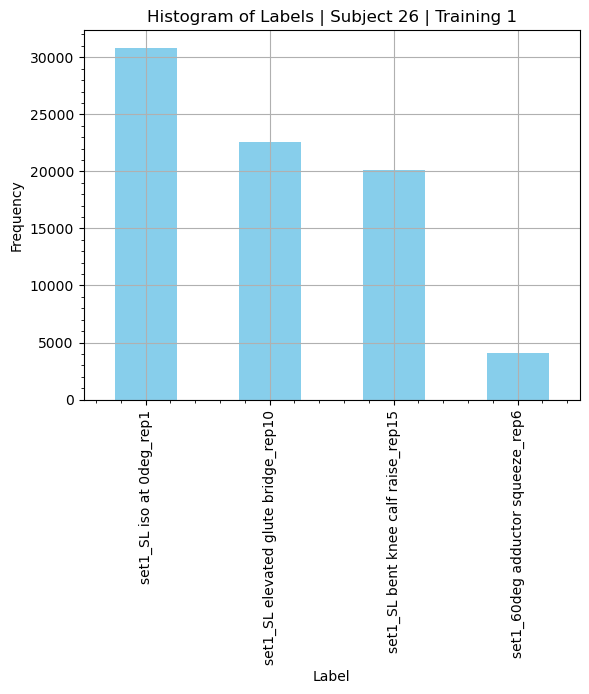

In [20]:
#example test
print(all_subjects_data[22][0].shape[0])
print(subjects)
# all_subjects_data[which subject][which training][single pickle file]
# subjects[which subject] = number of training files for that subject

#fig, axs = plt.subplots(10, 4)
for i in range(26):
    for j in range(int(subjects[i])):
        df = all_subjects_data[i][j]
        label_column = df.iloc[:, -1]
        label_counts = label_column.value_counts()
        label_counts = label_counts[1:]
        label_counts.plot(kind='bar', color='skyblue')
        plt.xlabel('Label')
        plt.ylabel('Frequency')
        #plt.yticks(np.linspace(min(label_counts), max(label_counts), len(label_counts)))
        plt.title('Histogram of Labels | Subject ' + str(i+1) + ' | Training ' + str(j+1))
        plt.grid(True)
        plt.minorticks_on()
        plt.show()

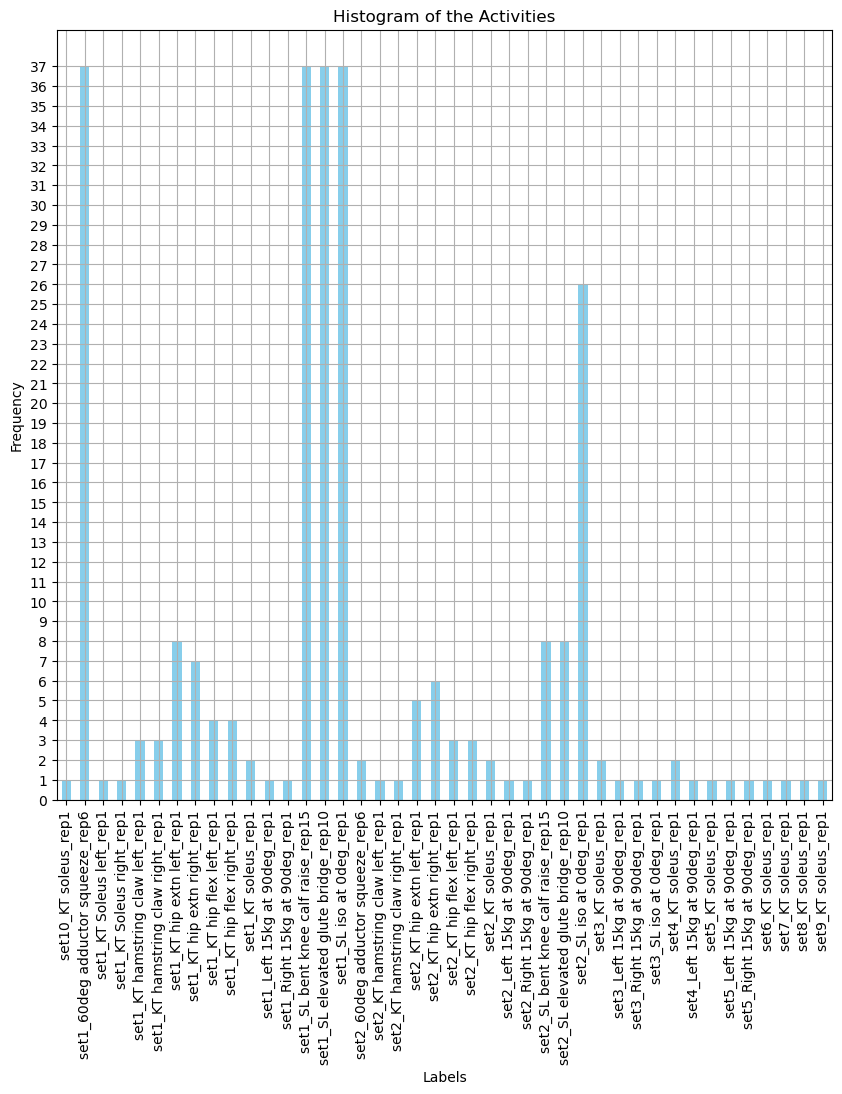

In [57]:
# This script writes details of the whole dataset into a text file.
labels_all = []
with open('subjects_trainings.txt', 'w') as f:
    for i in range(26):
        f.write(f"\n******** Subject {i+1} has {int(subjects[i])} training files. ********\n")
        
        for j in range(int(subjects[i])):
            size_pickles = all_subjects_data[i][j].shape
            f.write(f"\nSubject: {i+1} | training: {j+1} | pickle total number of data point: {size_pickles[0]} | pickle number of muscles: {size_pickles[1]-1}\n")
            df = all_subjects_data[i][j]
            columns = df.columns[:-1]
            f.write(f"Muscles: {', '.join(columns)}\n")
            
            labels = df['label'].unique()

            for label in labels[1:]:
                labels_all.append(label)
                f.write(f"Label: {label} has {df.loc[df['label'] == label].shape[0]} rows.\n")

plt.figure(figsize=(10,10))
pd.Series(labels_all).value_counts().sort_index().plot(kind='bar', color='skyblue')
# num_total_activity = len(set(labels_all))
# plt.hist(labels_all,bins=num_total_activity, color='skyblue', edgecolor='black')
#plt.xticks(rotation='vertical', fontsize=10)
plt.yticks(np.linspace(0, 37,38,dtype=int))
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Histogram of the Activities')
plt.grid(True)
plt.show()

with open('all_activities.txt', 'w') as f:
    f.write(f"\n******** Total number of activities (with occurences): {len(labels_all)} ********\n")
    f.write(f"\n******** Number of unique activities: {len(pd.Series(labels_all).unique())} ********\n")
    f.write(f"\n******** Occurences of activities: ********\n {pd.Series(labels_all).value_counts().sort_index()}")    

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # Hz
    low = lowcut / nyq # between 0,1
    high = highcut / nyq # between 0,1
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = lfilter(b, a, data)
    return y

(10944,)


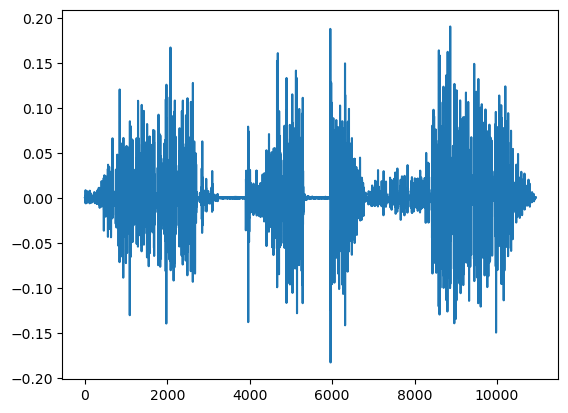

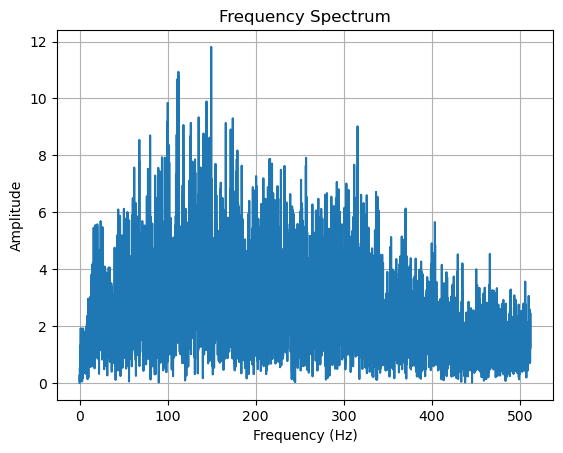

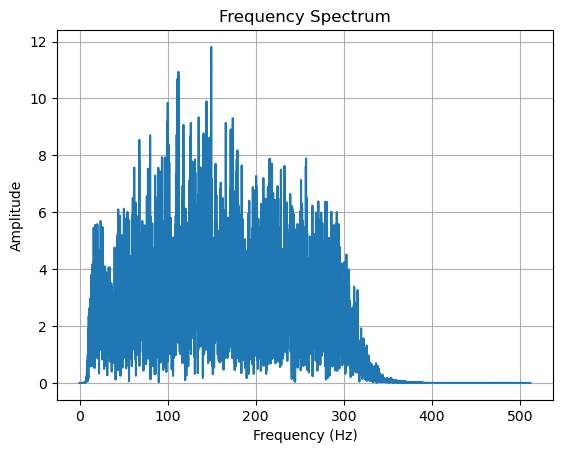

In [ ]:
#butterworth filter

low_cut = 10
high_cut = 300
order = 9
fs = 1024
filtered_sample = butter_bandpass_filter(sample, low_cut, high_cut, fs, order)
print(filtered_sample.shape)
plt.figure(0)
plt.plot(filtered_sample, label='after butterworth filter')

plt.figure(1)
data_fft = np.fft.fft(sample)
freqs = np.fft.fftfreq(len(sample), 1/fs)  # Calculate frequencies,  if the sample spacing is in seconds, then the frequency unit is cycles/second.
plt.plot(freqs[:len(freqs)//2], np.abs(data_fft)[:len(freqs)//2])  # Plot only positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show() 
fft_filtered_signal = np.fft.fft(filtered_sample)
freqs_filt = np.fft.fftfreq(len(filtered_sample), 1/fs)  # Calculate frequencies,  if the sample spacing is in seconds, then the frequency unit is cycles/second.
plt.plot(freqs[:len(freqs_filt)//2], np.abs(fft_filtered_signal)[:len(freqs_filt)//2])  # Plot only positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show()


In [ ]:
# mu-law tarnsformation to magnify the output of sensors with small magnitude, concentrate quantization noise in lower amplitude regions
def mu_law_encoding(signal, mu=128):
    mu_law = np.sign(signal) * np.log(1 + mu * np.abs(signal)) / np.log(1 + mu)
    return mu_law

(10944,)


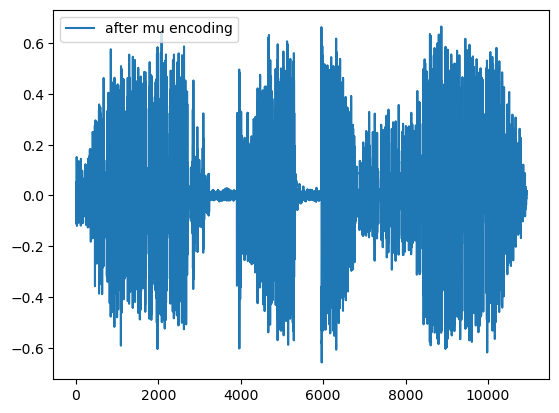

In [ ]:
encoded_sample = mu_law_encoding(filtered_sample)
print(encoded_sample.shape)
#plt.plot(filtered_sample, label='after butterworth filter')
plt.plot(encoded_sample, label='after mu encoding')
plt.legend()

(10944,)


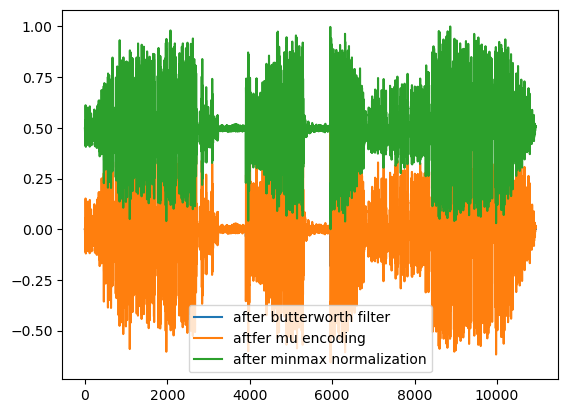

In [ ]:
#minimax normalization
normal_sample = (encoded_sample - np.nanmin(encoded_sample)) / (np.nanmax(encoded_sample) - np.nanmin(encoded_sample))
print(normal_sample.shape)
plt.plot(filtered_sample, label='after butterworth filter')
plt.plot(encoded_sample, label='aftfer mu encoding')
plt.plot(normal_sample, label='after minmax normalization')
plt.legend()

In [ ]:
def to_frame(raw_data, frame_size, overlap):
    if overlap == 0:
        # Split data into chunks without overlap
        return raw_data[: raw_data.shape[0] - raw_data.shape[0] % frame_size].reshape(-1, frame_size)

   
    num_frames = int(np.floor((raw_data.shape[0] - frame_size) / overlap + 1))
    print("num_frames", num_frames)
    indices = np.arange(frame_size) + np.expand_dims(np.arange(num_frames) * overlap, 1)

    return raw_data[indices]

def to_frame_single(raw_data, frame_size, overlap): # overlap sayısı kadar şift, frame_size - overlap kadar ortak
    if overlap == 0:
        iter = int(raw_data.shape[0]/frame_size)
        frames = np.zeros([iter, frame_size])
        for k in range(iter):
            frames[k, :] = raw_data[((k)*frame_size):((k+1)*frame_size)]
    else:
        iter = int(np.floor((raw_data.shape[0]-frame_size)/overlap+1))
        if( iter < 0):
            iter = 0
        frames = np.zeros([iter, frame_size])
        for k in range(iter):
            frames[k, :] = raw_data[((k)*overlap):((k)*overlap+frame_size)]
    return frames

In [ ]:
print(sample.shape)
framed_date = to_frame_single(sample, 400, 20) 
framed_date.shape

(10944,)


(528, 400)

In [ ]:
def wavelet_denoising(x):
    # Perform a Multilevel 1D Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(x, 'sym8')
    # Set a threshold value (this may need to be adjusted based on your specific signal)
    threshold = 0.001
    # Threshold the detail coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]
    # Perform an Inverse DWT to reconstruct the signal
    reconstructed_signal = pywt.waverec(coeffs_thresholded, 'sym8')
    return reconstructed_signal
